# <center> **`Banking Insights: Marketing Analysis & Prediction of Term Deposit Subscriptions`**

# **`1. Import Required Libraries`**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

%matplotlib inline
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder, FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# **`2. Load Data`**

In [2]:
data = pd.read_csv('data.csv')
df = pd.read_csv('data_basic_cleaning.csv')
eda_df = pd.read_csv('data_eda.csv')
print('Data Loaded')

Data Loaded


# **`3. Data Preparation`**
## **`3.1. Separating Independent Variables and Dependent Variable`**

In [3]:
X = df.drop('target', axis = 1)
y = df['target']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (45211, 16)
Shape of y: (45211,)


## **`3.2. Splitting Data into Train, Validation & Test sets`**

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 1, stratify = y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, 
                                                random_state = 28, stratify = y_temp)
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}\n")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nTraining Set (y_train):")
print(y_train.value_counts(normalize=True)*100)
print(f"\nValidation Set (y_val):")
print(y_val.value_counts(normalize=True)*100)
print(f"\nTest Set (y_test):")
print(y_test.value_counts(normalize=True)*100)

X_train shape: (36168, 16)
X_val shape: (4521, 16)
X_test shape: (4522, 16)

y_train shape: (36168,)
y_val shape: (4521,)
y_test shape: (4522,)

Training Set (y_train):
target
no     88.301814
yes    11.698186
Name: proportion, dtype: float64

Validation Set (y_val):
target
no     88.299049
yes    11.700951
Name: proportion, dtype: float64

Test Set (y_test):
target
no     88.301636
yes    11.698364
Name: proportion, dtype: float64


# **`4. Feature Engineering`**

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 17522 to 36453
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.7+ MB


In [6]:
def cap_outliers(ser):
    Q1, Q3 = ser.quantile([0.25,0.75])
    IQR = Q3 - Q1

    LL = Q1 - (1.5 * IQR)
    UL = Q3 + (1.5 * IQR)

    ser = np.where(ser <= LL, LL,
                  np.where(ser >= UL, UL, ser)
                  )
    return ser

def group_job_categories(df):
    df = df.copy()
    df['job_group'] = df['job'].apply(
        lambda job: (
            'self-driven' if job in ['self-employed', 'entrepreneur', 'housemaid']
            else 'unemployed' if job in ['student', 'unemployed']
            else job
        )
    )
    return df

def map_quarters(df):
    df = df.copy()
    df['quarter'] = df['month'].map({'apr':1,'may':1,'jun':1, 
                                     'jul':2,'aug':2,'sep':2, 
                                     'oct':3,'nov':3,'dec':3, 
                                     'jan':4,'feb':4,'mar':4}
                                   ).astype('int')
    return df

def map_week(df):
    df = df.copy()
    df = df.assign(
           week = lambda df_: pd.cut(df_['day'], bins = [0,7,14,21,31], labels = [1,2,3,4]).astype('int')
        )
    return df

def map_age(df):
    df = df.copy()
    q1 = df['age'].quantile(0.25)
    q3 = df['age'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    
    df = df.assign(
        is_age_outlier = lambda df_: ((df_['age'] < lower_limit) | (df_['age'] > upper_limit)).astype('int'),
        age_group = lambda df_: pd.cut(df_['age'], bins = [17,29,35,40,45,50,100], 
                                       labels = ['Young Adults', 'Early Professionals', 'Mid-Career', 
                                                 'Established Professionals', 'Pre-Retirement', 
                                                 'Seniors']).astype('category')
    )
    return df

def transform_balance(df):
    df = df.copy()
    df = (
        df
        .assign(
            balance_transform = lambda df_: np.log1p(df_['balance']- df_['balance'].min() + 1),
            balance_group = lambda df_: pd.cut(df_['balance'], bins = [float('-inf'),208,1293,2378,float('inf')],
                                              labels = ['low', 'medium-low', 'medium-high', 'high']).astype('category')
        )
        .drop(columns = ['balance'])
    )
    return df

def transform_duration(df):
    df = df.copy()
    df = (
        df
        .assign(
            duration_transform = lambda df_: np.log1p(df_['duration']- df_['duration'].min() + 1),
            duration_group = lambda df_: pd.cut(df_['duration'], bins = [-1,120,240,360,480,float('inf')],
                                               labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']).astype('category')
        )
        .drop(columns = ['duration'])
    )
    return df

def cap_campaign(df):
    df = df.copy()
    df['campaign'] = df['campaign'].pipe(cap_outliers)
    return df

def transform_pdays_previous(df):
    df = df.copy()
    df = (
        df
        .assign(
            contacted_previously = lambda df_: (df_['pdays'] != -1).astype('int')
        )
        .drop(columns = ['pdays', 'previous'])
    )
    return df

# **`5. Data Preprocessing`**

In [7]:
numeric_scaler = Pipeline(steps = [
    ('imputation', SimpleImputer(strategy = 'median')),
    ('scaling', StandardScaler())
])

nominal_encoder = Pipeline(steps = [
    ('imputation', SimpleImputer(strategy = 'most_frequent')),
    ('encoding', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore', drop = 'first'))
])

ordinal_encoder = Pipeline(steps = [
    ('imputation', SimpleImputer(strategy = 'most_frequent')),
    ('encoding', OrdinalEncoder(categories = 'auto', handle_unknown = 'error')),
    ('scaling', StandardScaler())
])

In [8]:
class EnrichmentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return (
            X.copy()
            .pipe(group_job_categories)
            .pipe(map_quarters)
            .pipe(map_week)
            .pipe(map_age)
            .pipe(transform_balance)
            .pipe(transform_duration)
            .pipe(cap_campaign)
            .pipe(transform_pdays_previous)
        )

class JobGroupMeanEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        self.means = pd.DataFrame({'job_group': X['job_group'], 'target': y}).groupby('job_group')['target'].mean().to_dict()
        return self

    def transform(self, X):
        return pd.DataFrame({'job_group_mean': X['job_group'].map(self.means).fillna(0)})

    def get_feature_names_out(self, input_features=None):
        return ['job_group_mean']

class JobGroupMeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping = None

    def fit(self, X, y):
        df = pd.DataFrame({'job_group': X['job_group'], 'target': y})
        self.mapping = df.groupby('job_group')['target'].mean().to_dict()
        return self

    def transform(self, X):
        if self.mapping is None:
            raise ValueError("Encoder has not been fitted yet.")
        return pd.DataFrame({'job_group_mean': X['job_group'].map(self.mapping).fillna(0)})

    def get_feature_names_out(self, input_features=None):
        return ['job_group_mean']

In [9]:
final_preprocessor = Pipeline([
    ('enrich', EnrichmentTransformer()),
    ('encode', ColumnTransformer([
        ('job_group_mean', JobGroupMeanEncoder(), ['job_group']),
        ('ordinal', ordinal_encoder, ['education', 'balance_group', 'duration_group']),
        ('nominal', nominal_encoder, ['age_group', 'marital', 'job_group', 'default', 'housing',
                                      'loan', 'contact', 'month', 'poutcome']),
        ('numeric', numeric_scaler, ['age', 'is_age_outlier', 'day', 'week', 'quarter',
                                     'balance_transform', 'duration_transform', 'campaign'])
    ], remainder='drop', verbose_feature_names_out=True))
])

In [10]:
final_preprocessor

Pipeline(steps=[('enrich', EnrichmentTransformer()),
                ('encode',
                 ColumnTransformer(transformers=[('job_group_mean',
                                                  JobGroupMeanEncoder(),
                                                  ['job_group']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['education', 'balance_group',
                                                   'duration_group']),
                                                 ('nominal',...
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'marital',
                                                   'job_group', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['age', 'is_age_outlier',
                                                   'day', 'week', 'quarter',
                                                   'balance_transform',
                                                   'duration_transform',
                                                   'campaign'])]))])

In [11]:
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_temp   = target_encoder.transform(y_temp)
y_val   = target_encoder.transform(y_val)
y_test  = target_encoder.transform(y_test)

In [12]:
X_train = final_preprocessor.fit_transform(X_train, y_train)
X_val = final_preprocessor.transform(X_val)
X_temp = final_preprocessor.transform(X_temp)
X_test = final_preprocessor.transform(X_test)

In [13]:
feature_names = final_preprocessor.named_steps['encode'].get_feature_names_out()
X_train_df = pd.DataFrame(X_train, columns = feature_names)
X_temp_df = pd.DataFrame(X_temp, columns = feature_names)
X_val_df = pd.DataFrame(X_val, columns = feature_names)
X_test_df = pd.DataFrame(X_test, columns = feature_names)

# **`6. Correlation Analysis`**

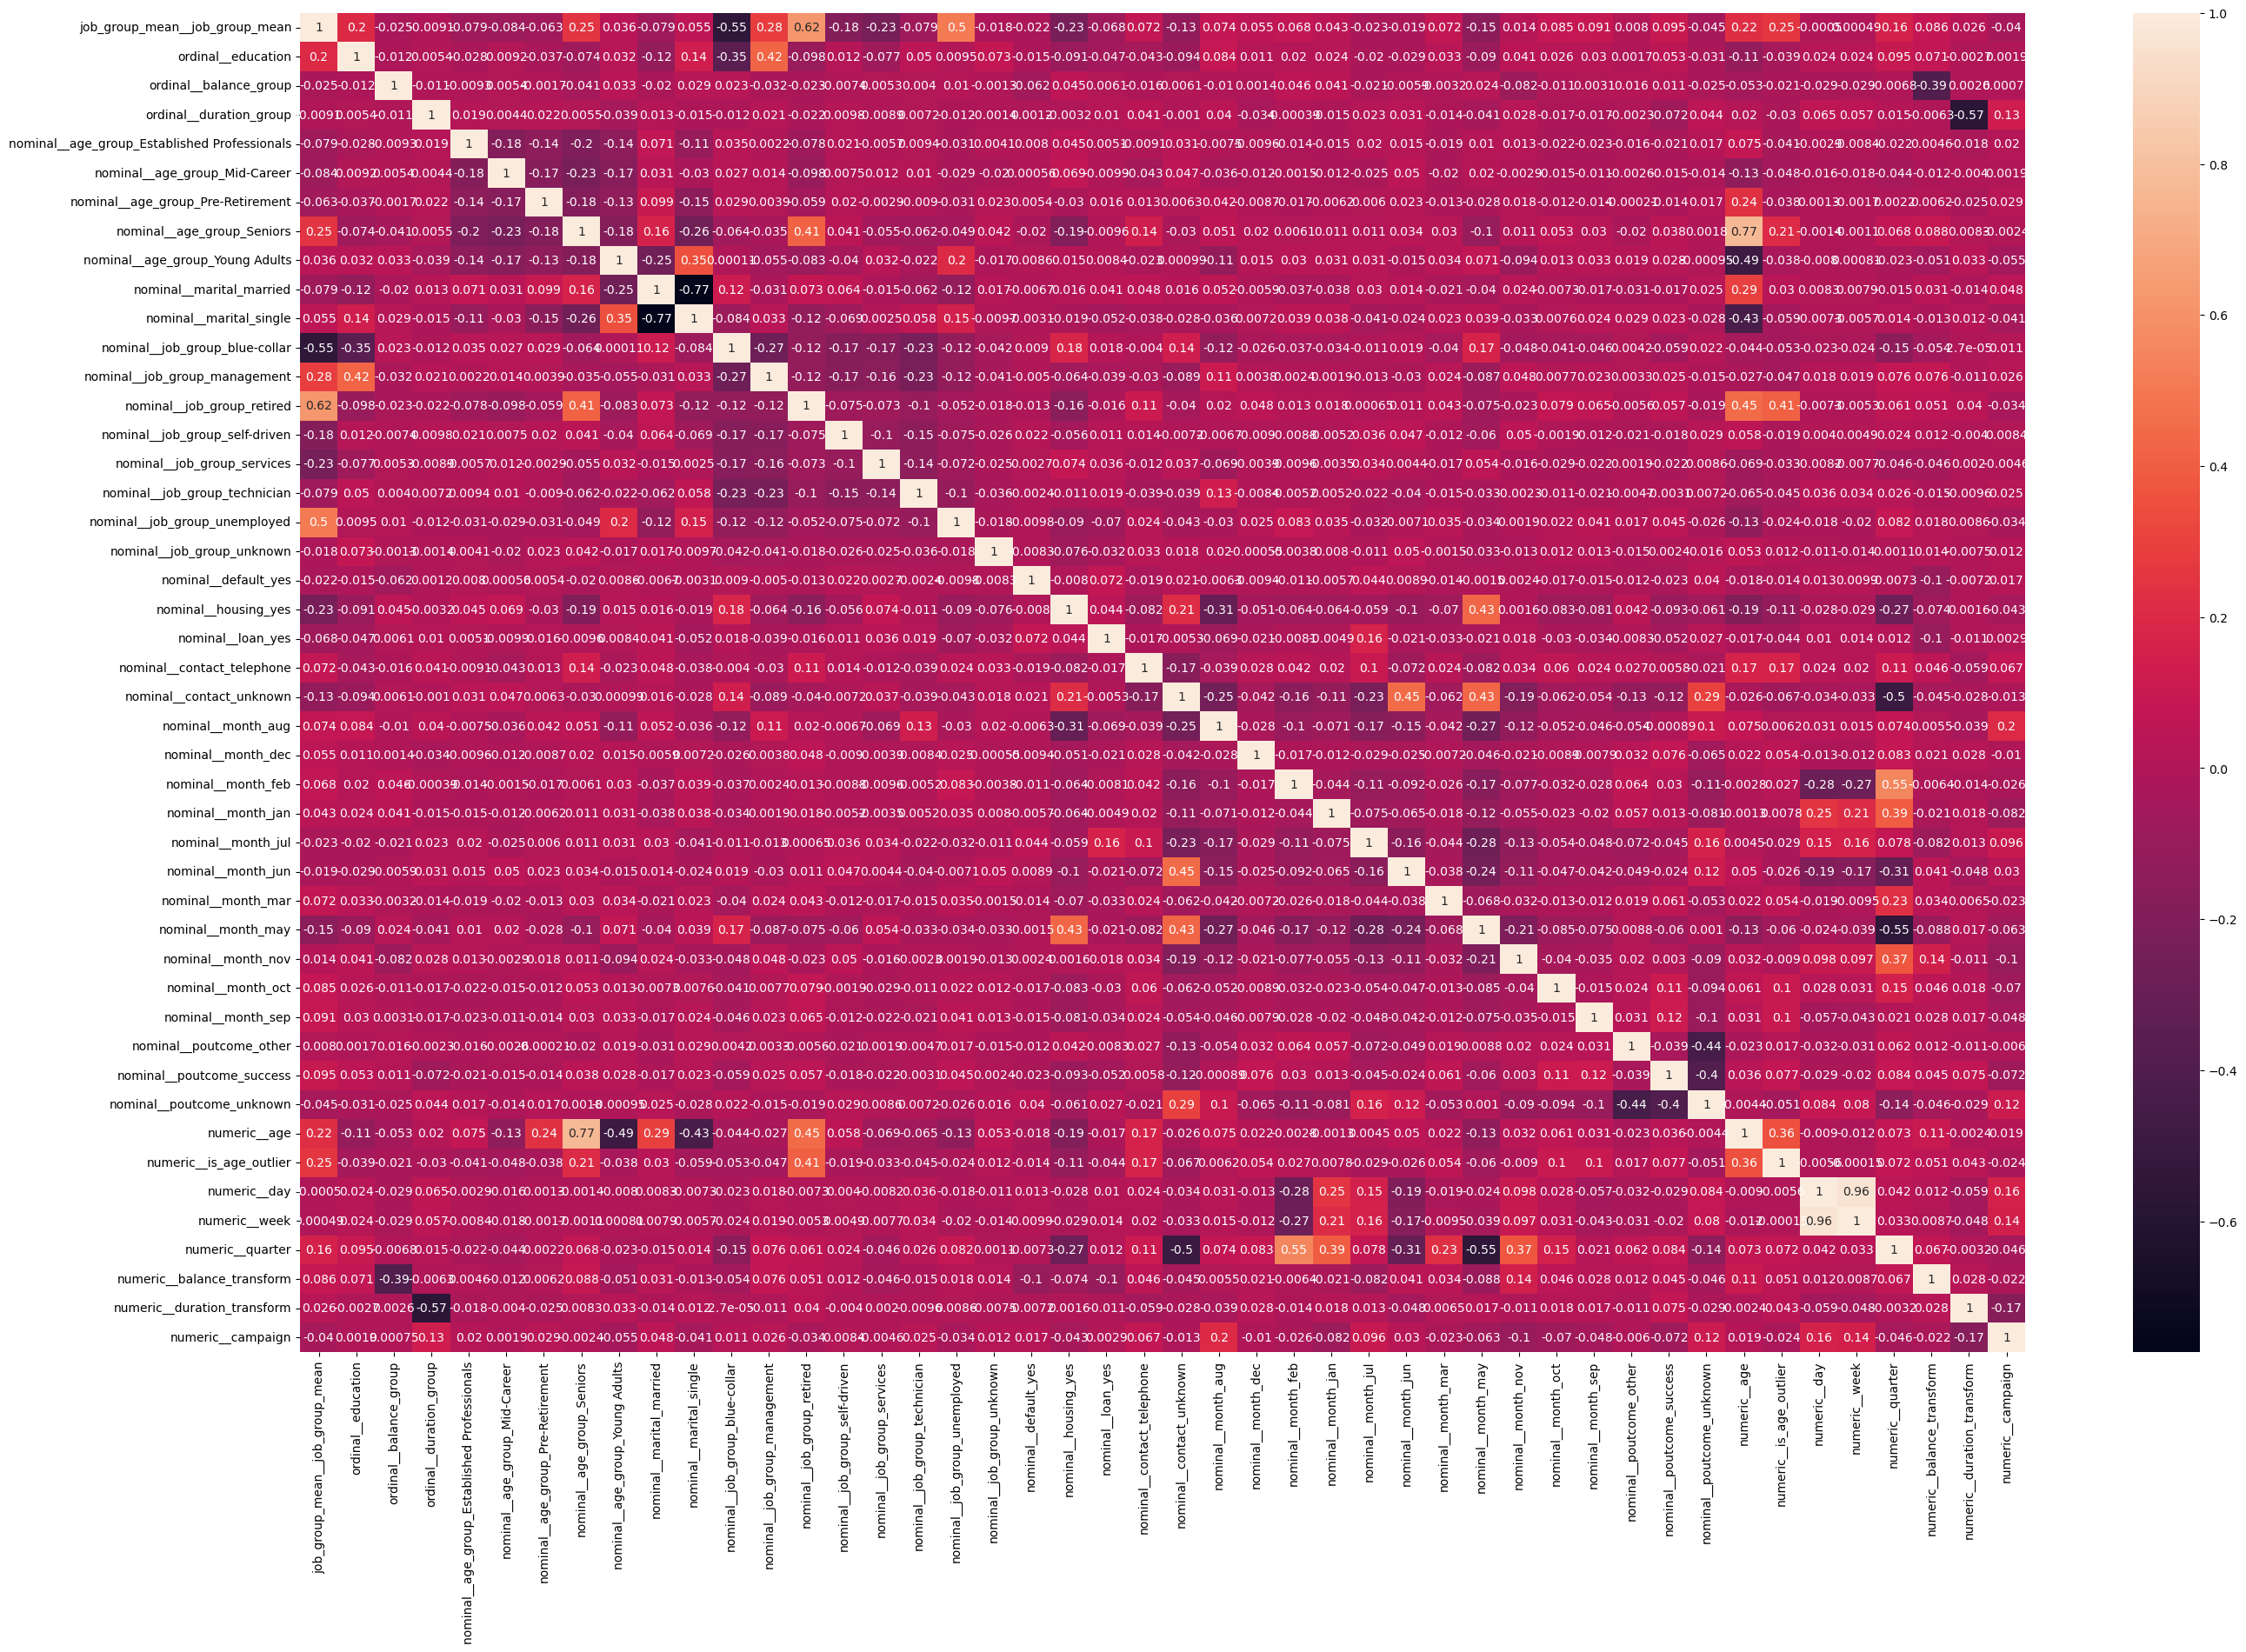

In [14]:
plt.figure(figsize = (32,20))
sns.heatmap(X_train_df.corr(), annot = True)
plt.show()

#### **`Observation`**
- **Day** & **Week** show strong multicollinearity **(0.96)**.
- We will remove **Week** feature to deal with multicolinearity.

# **`7. Model Ready Data`**
## **`7.1. Data Cleaning`**

In [15]:
X_train_df = X_train_df.drop(columns=['numeric__week'])
X_temp_df = X_temp_df.drop(columns=['numeric__week'])
X_val_df = X_val_df.drop(columns=['numeric__week'])
X_test_df = X_test_df.drop(columns=['numeric__week'])

In [16]:
X_train_df.head(2)

,job_group_mean__job_group_mean,ordinal__education,ordinal__balance_group,ordinal__duration_group,nominal__age_group_Established Professionals,nominal__age_group_Mid-Career,nominal__age_group_Pre-Retirement,nominal__age_group_Seniors,nominal__age_group_Young Adults,nominal__marital_married,...,nominal__poutcome_other,nominal__poutcome_success,nominal__poutcome_unknown,numeric__age,numeric__is_age_outlier,numeric__day,numeric__quarter,numeric__balance_transform,numeric__duration_transform,numeric__campaign
0,0.109619,-0.300003,-0.615188,1.217900,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.099649,-0.10508,1.59041,0.184567,-0.647723,-2.960481,2.253035
1,0.139698,1.035607,-0.615188,-1.881524,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.853196,-0.10508,-0.09365,-0.834736,-0.540712,0.860992,-0.245459


In [17]:
print(f"X_train shape: {X_train_df.shape}")
print(f"X_val shape: {X_val_df.shape}")
print(f"X_test shape: {X_test_df.shape}\n")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (36168, 45)
X_val shape: (4521, 45)
X_test shape: (4522, 45)

y_train shape: (36168,)
y_val shape: (4521,)
y_test shape: (4522,)


## **`7.2. SMOTE (Synthetic Minority Over-sampling Technique)`**

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_df, y_train)

In [19]:
unique, counts = np.unique(y_train_sm, return_counts=True)
print(dict(zip(unique, counts)))

{0: 31937, 1: 31937}


In [20]:
X_train_df.to_csv("X_train.csv", index = False)
X_train_sm.to_csv("X_train_resampled.csv", index = False)
X_temp_df.to_csv("X_temp.csv", index = False)
X_val_df.to_csv("X_val.csv", index = False)
X_test_df.to_csv("X_test.csv", index = False)

y_train_df = pd.DataFrame(y_train)
y_train_sm_df = pd.DataFrame(y_train_sm)
y_temp_df = pd.DataFrame(y_temp)
y_val_df = pd.DataFrame(y_val)
y_test_df = pd.DataFrame(y_test)

y_train_df.to_csv("y_train_df.csv", index = False)
y_train_sm_df.to_csv("y_train_resampled.csv", index = False)
y_temp_df.to_csv("y_temp_df.csv", index = False)
y_val_df.to_csv("y_val_df.csv", index = False)
y_test_df.to_csv("y_test_df.csv", index = False)

# **`8. Model Building`**

In [21]:
def model_evaluate(clf, train_X, train_y, test_X, test_y, target_precision = None):
    clf.fit(train_X, train_y)
    
    y_pred_train = clf.predict(train_X)
    y_pred_test = clf.predict(test_X)
    y_probs_test = clf.predict_proba(test_X)[:, 1]
    y_probs_train = clf.predict_proba(train_X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(test_y, y_probs_test)

    if target_precision != None:
        target_precision = target_precision
        idx = np.argmax(precision >= target_precision)
        chosen_threshold = thresholds[idx]
    
        y_pred_custom = (y_probs_test >= chosen_threshold).astype(int)
        train_accuracy = accuracy_score(train_y, y_pred_train)
        test_accuracy = accuracy_score(test_y, y_pred_custom)
        roc_auc_train = roc_auc_score(train_y, y_probs_train)
        roc_auc_test = roc_auc_score(test_y, y_pred_custom)

        print(f"Selected Threshold: {chosen_threshold:0.3f}")
        print('-'*55)
        print(f"Train Accuracy: {train_accuracy:0.3f}")
        print(f"Test Accuracy: {test_accuracy:0.3f}")
        print('-'*55)
        print(f"Train ROC-AUC Score: {roc_auc_train:.3f}")
        print(f"Test ROC-AUC Score: {roc_auc_test:.3f}")

        print('-'*55)
        print(f"\n Classification Report:\n {classification_report(test_y, y_pred_custom)}")
        print('-'*55)
        
        cm = confusion_matrix(test_y, y_pred_custom)
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.title('Confusion Matrix')
        plt.xticks([0,1],['No', 'Yes'])
        plt.yticks([0,1],['No', 'Yes'])
        plt.show()

    else:
        train_accuracy = accuracy_score(train_y, y_pred_train)
        test_accuracy = accuracy_score(test_y, y_pred_test)
        roc_auc_train = roc_auc_score(train_y, y_probs_train)
        roc_auc_test = roc_auc_score(test_y, y_probs_test)
    
        print(f"Selected Threshold: 0.50")
        print('-'*55)
        print(f"Train Accuracy: {train_accuracy:0.3f}")
        print(f"Test Accuracy: {test_accuracy:0.3f}")
        print('-'*55)
        print(f"Train ROC-AUC Score: {roc_auc_train:.3f}")
        print(f"Test ROC-AUC Score: {roc_auc_test:.3f}")
        
        print('-'*55)
        print(f"\n Classification Report:\n {classification_report(test_y, y_pred_test)}")
        print('-'*55)
        
        cm = confusion_matrix(test_y, y_pred_test)
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.title('Confusion Matrix')
        plt.xticks([0,1],['No', 'Yes'])
        plt.yticks([0,1],['No', 'Yes'])
        plt.show()

## **`8.1. Logistic Regression`**

Logistic Regression Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.852
Test Accuracy: 0.865
-------------------------------------------------------
Train ROC-AUC Score: 0.922
Test ROC-AUC Score: 0.908
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      7985
           1       0.45      0.77      0.57      1058

    accuracy                           0.87      9043
   macro avg       0.71      0.82      0.75      9043
weighted avg       0.91      0.87      0.88      9043

-------------------------------------------------------


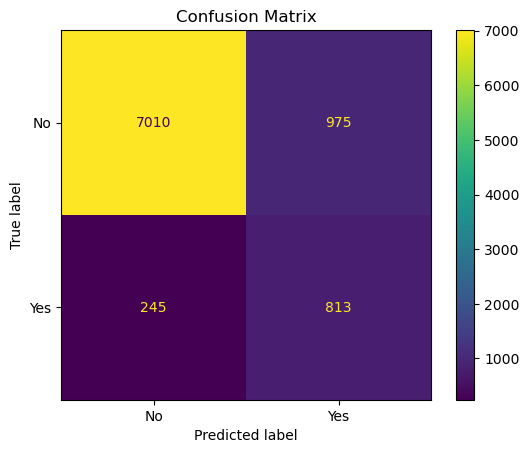

In [22]:
lr = LogisticRegression()
print("Logistic Regression Summary:\n")
model_evaluate(lr, X_train_sm, y_train_sm, X_temp_df, y_temp)

## **`8.2. K-Nearest Neighbor`**

K - Nearest Neighbor Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.940
Test Accuracy: 0.753
-------------------------------------------------------
Train ROC-AUC Score: 0.999
Test ROC-AUC Score: 0.761
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85      7985
           1       0.27      0.64      0.38      1058

    accuracy                           0.75      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.75      0.79      9043

-------------------------------------------------------


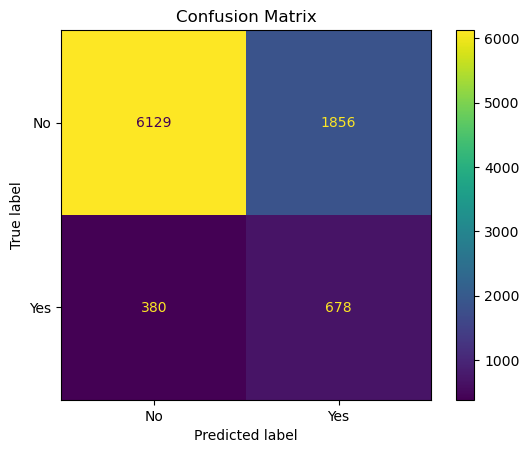

In [23]:
knn = KNeighborsClassifier()
print("K - Nearest Neighbor Summary:\n")
model_evaluate(knn, X_train_sm, y_train_sm, X_temp_df, y_temp)

## **`8.3. Decision Tree`**

Decision Tree Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 1.000
Test Accuracy: 0.853
-------------------------------------------------------
Train ROC-AUC Score: 1.000
Test ROC-AUC Score: 0.674
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92      7985
           1       0.39      0.44      0.41      1058

    accuracy                           0.85      9043
   macro avg       0.66      0.67      0.66      9043
weighted avg       0.86      0.85      0.86      9043

-------------------------------------------------------


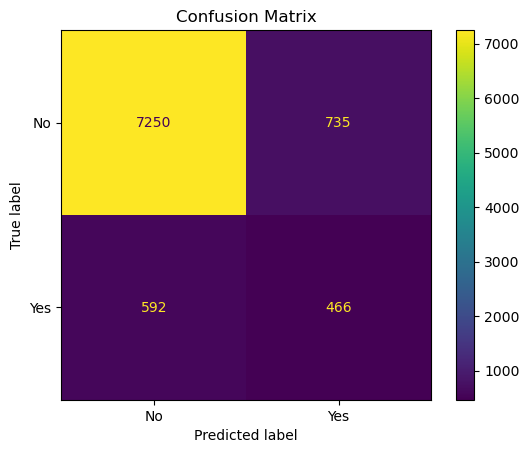

In [24]:
dt = DecisionTreeClassifier()
print("Decision Tree Summary:\n")
model_evaluate(dt, X_train_sm, y_train_sm, X_temp_df, y_temp)

## **`8.4. Random Forest`**

Random Forest Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 1.000
Test Accuracy: 0.896
-------------------------------------------------------
Train ROC-AUC Score: 1.000
Test ROC-AUC Score: 0.921
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7985
           1       0.58      0.39      0.47      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.68      0.70      9043
weighted avg       0.88      0.90      0.89      9043

-------------------------------------------------------


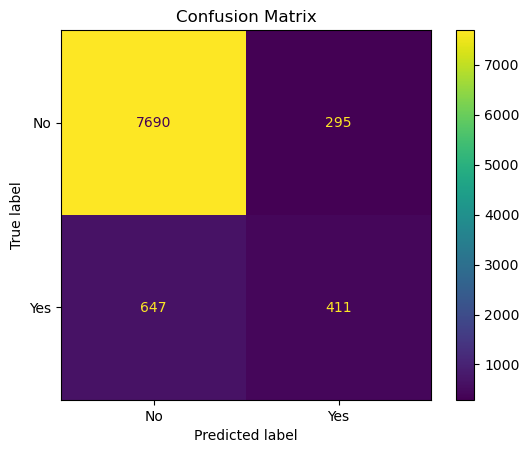

In [25]:
rfc = RandomForestClassifier()
print("Random Forest Summary:\n")
model_evaluate(rfc, X_train_sm, y_train_sm, X_temp_df, y_temp)

Random Forest (Tuned) Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.921
Test Accuracy: 0.878
-------------------------------------------------------
Train ROC-AUC Score: 0.979
Test ROC-AUC Score: 0.914
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      7985
           1       0.48      0.69      0.57      1058

    accuracy                           0.88      9043
   macro avg       0.72      0.80      0.75      9043
weighted avg       0.90      0.88      0.89      9043

-------------------------------------------------------


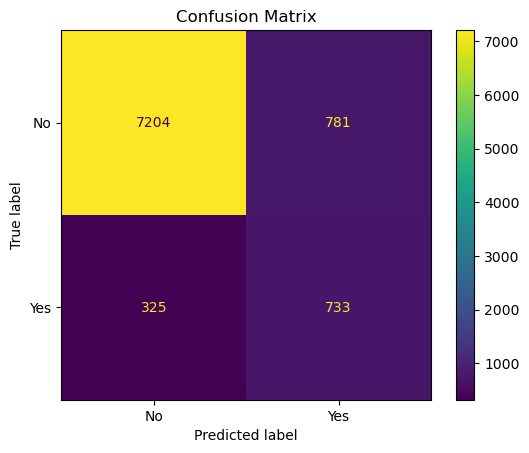

In [26]:
rfc_tuned = RandomForestClassifier(max_depth = 10, random_state = 2)
print("Random Forest (Tuned) Summary:\n")
model_evaluate(rfc_tuned, X_train_sm, y_train_sm, X_temp_df, y_temp)

## **`8.5. Gradient Boosting`**

Gradient Boosting Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.927
Test Accuracy: 0.889
-------------------------------------------------------
Train ROC-AUC Score: 0.981
Test ROC-AUC Score: 0.916
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      7985
           1       0.52      0.63      0.57      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.78      0.75      9043
weighted avg       0.90      0.89      0.89      9043

-------------------------------------------------------


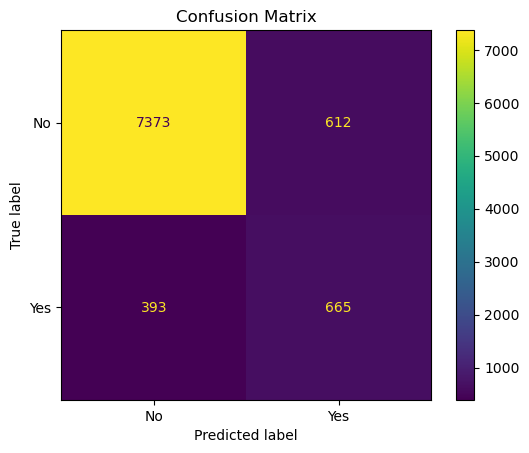

In [27]:
gb = GradientBoostingClassifier()
print("Gradient Boosting Summary:\n")
model_evaluate(gb, X_train_sm, y_train_sm, X_temp_df, y_temp)

Gradient Boosting (Tuned) Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.913
Test Accuracy: 0.883
-------------------------------------------------------
Train ROC-AUC Score: 0.971
Test ROC-AUC Score: 0.909
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      7985
           1       0.50      0.66      0.57      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.79      0.75      9043
weighted avg       0.90      0.88      0.89      9043

-------------------------------------------------------


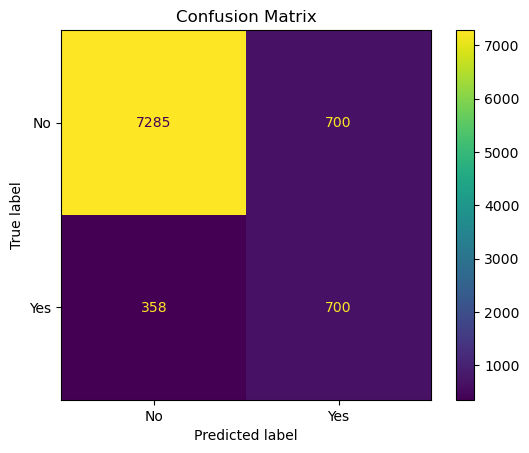

In [28]:
gb_tuned = GradientBoostingClassifier(max_depth = 2)
print("Gradient Boosting (Tuned) Summary:\n")
model_evaluate(gb_tuned, X_train_sm, y_train_sm, X_temp_df, y_temp)

## **`8.6. XG Boost`**

XG Boost Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.969
Test Accuracy: 0.900
-------------------------------------------------------
Train ROC-AUC Score: 0.997
Test ROC-AUC Score: 0.918
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.62      0.37      0.47      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.67      0.71      9043
weighted avg       0.89      0.90      0.89      9043

-------------------------------------------------------


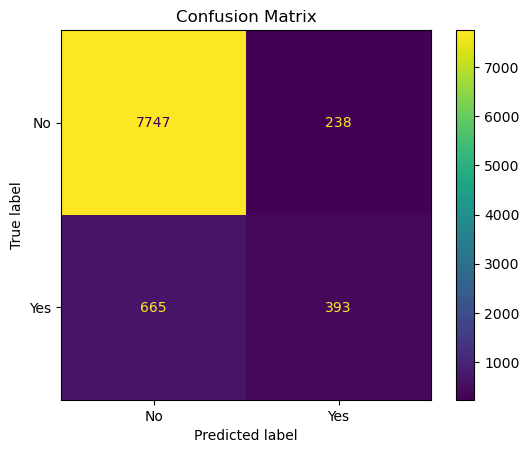

In [29]:
xgb = XGBClassifier()
print("XG Boost Summary:\n")
model_evaluate(xgb, X_train_sm, y_train_sm, X_temp_df, y_temp)

XG Boost (Tuned) Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.893
Test Accuracy: 0.881
-------------------------------------------------------
Train ROC-AUC Score: 0.954
Test ROC-AUC Score: 0.905
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      7985
           1       0.49      0.69      0.58      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.80      0.75      9043
weighted avg       0.90      0.88      0.89      9043

-------------------------------------------------------


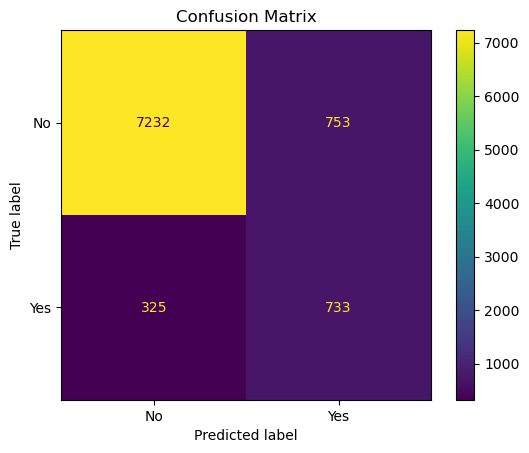

In [30]:
xgb_tuned = XGBClassifier(max_depth = 1)
print("XG Boost (Tuned) Summary:\n")
model_evaluate(xgb_tuned, X_train_sm, y_train_sm, X_temp_df, y_temp)

# **`9. Model Selection`**
## **`9.1. Comparison of Model Performances`**

In [31]:
model = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
precision_class0 = [0.97, 0.94, 0.92, 0.96, 0.95, 0.96]
precision_class1 = [0.45, 0.27, 0.38, 0.48, 0.50, 0.49]
recall_class0 = [0.88, 0.77, 0.91, 0.90, 0.91, 0.91]
recall_class1 = [0.77, 0.64, 0.44, 0.69, 0.66, 0.69]
f1_class0 = [0.92, 0.85, 0.92, 0.93, 0.93, 0.93]
f1_class1 = [0.57, 0.38, 0.41, 0.57, 0.57, 0.58]
train_accuracy = [0.852, 0.940, 1.000, 0.921, 0.913, 0.893]
test_accuracy = [0.865, 0.753, 0.852, 0.878, 0.883, 0.881]
train_roc_auc = [0.922, 0.999, 1.000, 0.979, 0.971, 0.954]
test_roc_auc = [0.908, 0.761, 0.675, 0.914, 0.909, 0.905]
overall_f1 = []

evaluation_comparison = pd.DataFrame(data = {'Model': model,
                                             'Accuracy (Train)': train_accuracy,
                                             'Accuracy (Test)': test_accuracy,
                                             'ROC-AUC (Train)': train_roc_auc, 
                                             'ROC-AUC (Test)': test_roc_auc,
                                             'Precision (Class-0)': precision_class0, 
                                             'Precision (Class-1)': precision_class1,
                                             'Recall (Class-0)': recall_class0, 
                                             'Recall (Class-1)': recall_class1,
                                             'F1 (Class-0)': f1_class0,
                                             'F1 (Class-1)': f1_class1, 
                                             })
evaluation_comparison = evaluation_comparison.set_index('Model')
display('Comparison of Metrics:', evaluation_comparison)

'Comparison of Metrics:'

,Accuracy (Train),Accuracy (Test),ROC-AUC (Train),ROC-AUC (Test),Precision (Class-0),Precision (Class-1),Recall (Class-0),Recall (Class-1),F1 (Class-0),F1 (Class-1)
Model,,,,,,,,,,
Logistic Regression,0.852,0.865,0.922,0.908,0.97,0.45,0.88,0.77,0.92,0.57
KNN,0.940,0.753,0.999,0.761,0.94,0.27,0.77,0.64,0.85,0.38
Decision Tree,1.000,0.852,1.000,0.675,0.92,0.38,0.91,0.44,0.92,0.41
Random Forest,0.921,0.878,0.979,0.914,0.96,0.48,0.90,0.69,0.93,0.57
Gradient Boosting,0.913,0.883,0.971,0.909,0.95,0.50,0.91,0.66,0.93,0.57
XGBoost,0.893,0.881,0.954,0.905,0.96,0.49,0.91,0.69,0.93,0.58


### **`Model Selection`**

- **XGBoost**:
    - Excellent strategic choice, balances recall with precision and interpretability.
    - Ideal for ranking-based campaigns and efficient outreach.
    - Strong balance; better F1 and robust ranking for confident targeting.

# **`10. Model Evaluation`**
## **`10.1. XGBoost - Performance Metrics`**

XG Boost Summary:

Selected Threshold: 0.50
-------------------------------------------------------
Train Accuracy: 0.893
Test Accuracy: 0.881
-------------------------------------------------------
Train ROC-AUC Score: 0.954
Test ROC-AUC Score: 0.905
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      7985
           1       0.49      0.69      0.58      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.80      0.75      9043
weighted avg       0.90      0.88      0.89      9043

-------------------------------------------------------


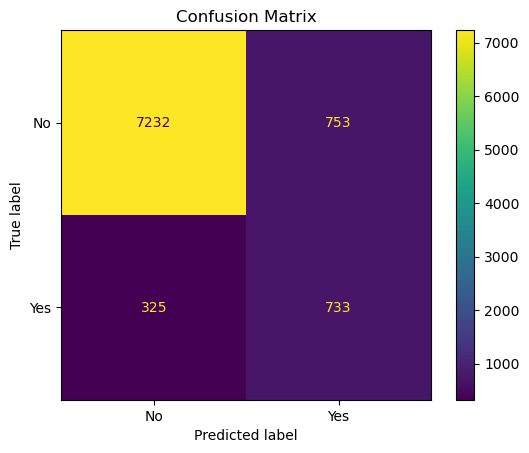

In [32]:
xgb_tuned = XGBClassifier(max_depth = 1)
print("XG Boost Summary:\n")
model_evaluate(xgb_tuned, X_train_sm, y_train_sm, X_temp_df, y_temp)

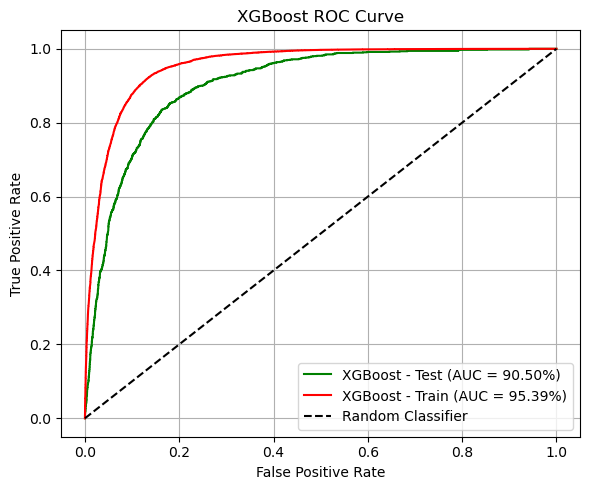

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

xgb_tuned.fit(X_train_sm, y_train_sm)
xgb_probs = xgb_tuned.predict_proba(X_temp_df)[:, 1]
xgb_probs_train = xgb_tuned.predict_proba(X_train_sm)[:, 1]

fpr, tpr, _ = roc_curve(y_temp, xgb_probs)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, _2 = roc_curve(y_train_sm, xgb_probs_train)
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost - Test (AUC = {roc_auc*100:.2f}%)', color='green')
plt.plot(fpr2, tpr2, label=f'XGBoost - Train (AUC = {roc_auc2*100:.2f}%)', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## **`10.2. Feature Importance`**

In [35]:
importances = xgb_tuned.feature_importances_
transformed_feature_names = X_train_sm.columns

mapping = {
    'numeric__duration_transform': 'duration',
    'ordinal__duration_group': 'duration',
    'nominal__housing_yes': 'housing',
    'nominal__loan_yes': 'loan',
    'nominal__month_mar': 'month',
    'nominal__month_oct': 'month',
    'nominal__month_sep': 'month',
    'nominal__month_aug': 'month',
    'nominal__month_may': 'month',
    'nominal__month_jan': 'month',
    'nominal__month_nov': 'month',
    'nominal__month_jul': 'month',
    'nominal__month_jun': 'month',
    'nominal__age_group_Young Adults': 'age',
    'nominal__age_group_Mid-Career': 'age',
    'nominal__age_group_Pre-Retirement': 'age',
    'nominal__age_group_Established Professionals': 'age',
    'nominal__age_group_Seniors': 'age',
    'numeric__age': 'age',
    'numeric__is_age_outlier': 'age',
    'ordinal__education': 'education',
    'nominal__marital_married': 'marital',
    'nominal__marital_single': 'marital',
    'job_group_mean__job_group_mean': 'job_group',
    'nominal__job_group_self-driven': 'job_group',
    'nominal__job_group_technician': 'job_group',
    'nominal__job_group_unemployed': 'job_group',
    'nominal__job_group_blue-collar': 'job_group',
    'nominal__job_group_services': 'job_group',
    'nominal__job_group_retired': 'job_group',
    'nominal__job_group_management': 'job_group',
    'nominal__job_group_unknown': 'job_group',
    'nominal__default_yes': 'default',
    'nominal__contact_unknown': 'contact',
    'nominal__contact_telephone': 'contact',
    'nominal__poutcome_success': 'poutcome',
    'nominal__poutcome_unknown': 'poutcome',
    'nominal__poutcome_other': 'poutcome',
    'numeric__balance_transform': 'balance',
    'ordinal__balance_group': 'balance',
    'numeric__campaign': 'campaign',
    'numeric__day': 'day',
    'numeric__quarter': 'quarter',
    'nominal__month_dec': 'month',
    'nominal__month_feb': 'month',
}

feat_df = pd.DataFrame({
    'TransformedFeature': transformed_feature_names,
    'Importance': importances
})
feat_df['OriginalFeature'] = feat_df['TransformedFeature'].map(mapping).fillna('Unmapped')
agg_df = feat_df.groupby('OriginalFeature')['Importance'].sum().reset_index()
agg_df = agg_df.sort_values(by='Importance', ascending=False)

display(agg_df)

,OriginalFeature,Importance
12,month,0.183481
6,duration,0.182556
13,poutcome,0.153007
9,job_group,0.105102
8,housing,0.089866
0,age,0.077432
3,contact,0.075484
10,loan,0.042955
1,balance,0.026411
2,campaign,0.024189


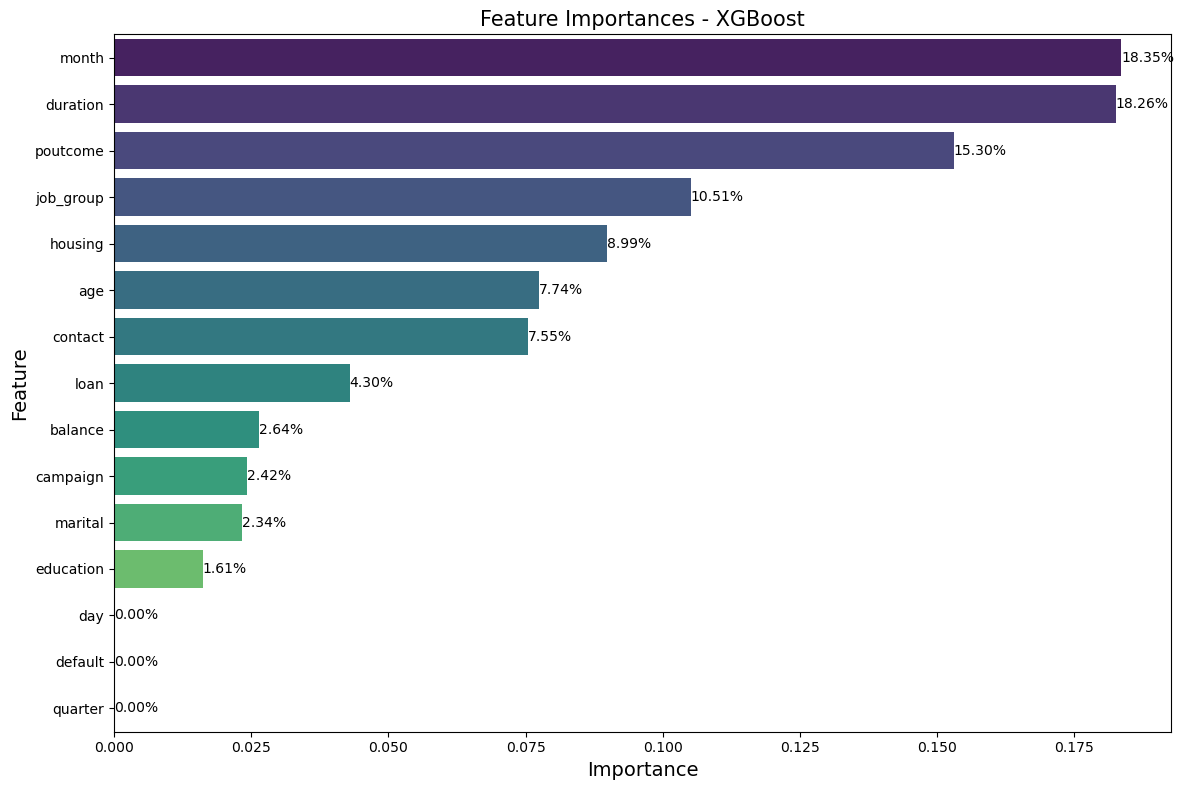

In [36]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x = 'Importance', y = 'OriginalFeature', hue = 'OriginalFeature',
                 data = agg_df, palette = 'viridis')
for bars in ax.containers:
    ax.bar_label(bars, labels = [f'{(label.get_width() * 100):0.2f}%' for label in bars], padding = 0)
plt.title("Feature Importances - XGBoost", fontsize = 15)
plt.xlabel("Importance", fontdict = {'fontsize': 14})
plt.ylabel("Feature", fontdict = {'fontsize': 14})
plt.tight_layout()
plt.show()

# **`11. Campaign Strategy Recommendations`**
 
**`1. Leverage Timing Signals`**
- Features like **month** and **duration** dominate, suggesting when and how long customers were engaged is critical.
- **Recommendation**: Run **time-sensitive campaigns** targeting high-duration contacts in top-performing months.
- **Cluster** responders by **duration_group** and **optimize** contact cadence.
  
**`2. Retarget Based on Past Success`**
- **poutcome_success** holds strong predictive power.
- Past campaign success is a goldmine for targeting, makes sense to double down on customers who've converted before.
- **Recommendation**: Segment leads with prior campaign success for **re-engagement loops**, possibly with **tailored offers or priority messaging**.

**`3. Segement Based Campaign`**
- **Socio-Economic** and **behavioral** traits here hint at who’s most receptive.
- **Recommendation**: Segment-based campaigns (e.g. job_group-wise messaging) could boost efficiency.

# **`12. Conclusion`**

The final XGBoost model, trained with a selected threshold of 0.50, demonstrates strong performance and strategic utility for enhancing marketing effectiveness in the bank’s term deposit campaigns.

**`Model Effectiveness`**
- **Test Accuracy**: **88.1%** - Indicates reliable overall prediction capability.
- **Test ROC-AUC Score**: **0.905** - Excellent class separability between responders and non-responders.
- **Class-1 (Responders) Recall**: **69%** - Captures a large portion of actual responders, helping ensure minimal missed opportunities.
- **Class-1 Precision**: **49%** - While modest, this is acceptable given the bank’s priority to minimize false negatives and reach more potential responders.

The model successfully balances recall-driven outreach and precision-aware resource efficiency, optimizing customer acquisition without excessive budget waste.

**`Business Implications`**
- The model supports **smarter targeting** by identifying customers most likely to respond, improving **conversion rates** and **campaign ROI**.
- With its **strong recall**, the bank can **expand outreach** confidently, knowing that the majority of true responders will be captured.
- Precision, while lower, can be mitigated by ranking and threshold tuning to prioritize high-confidence predictions, critical for campaign budgeting.

# **`13. Recommended Next Steps`**
- **Threshold Tuning**: Adjust cutoff points to meet campaign-specific precision-recall tradeoffs.
- **Lead Ranking Strategy**: Generate ranked responder lists using predicted probabilities for controlled budget deployment.
- **Segmented Outreach**: Use top features (e.g. duration, poutcome, month) to craft personalized messaging per customer cluster.